EXPLAINABLE CHAT DRIVEN LOAN RECOMMENDER

NECESSARY LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pickle
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import shap
import os
import joblib
from google.colab import files
!pip install imbalanced-learn

DATASET

In [ ]:
# Upload the file
uploaded = files.upload()

# Read the uploaded file into a DataFrame
import pandas as pd
df = pd.read_csv("train_ctrUa4K.csv")

print("Dataset uploaded and loaded successfully!")
df.head()  # Display first few rows

Saving train_ctrUa4K.csv to train_ctrUa4K.csv
Dataset uploaded and loaded successfully!


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
# Check number of rows and columns
print("Shape of the dataset (rows, columns):", df.shape)

# Display column-wise missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

Shape of the dataset (rows, columns): (614, 13)

Missing values in each column:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


PREPROCESSING

In [ ]:
# Fill categorical columns with mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill LoanAmount with median
df['LoanAmount']=df['LoanAmount'].fillna(df['LoanAmount'].median())

# Check again for missing values
print(df.isnull().sum())

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [ ]:
# Categorical columns
categorical_columns_for_encoding = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Amount_Term']

# Re-initialize or ensure label_encoders dictionary is correctly populated
# This part is typically done during the initial preprocessing of the training data
label_encoders = {}
for col in categorical_columns_for_encoding:
    le = LabelEncoder()
    try:
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    except Exception as e:
        print(f"Error fitting LabelEncoder for column {col}: {e}")
        print("Ensure the column contains appropriate data for encoding.")


# Numerical columns
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Encode target
target_encoder = LabelEncoder()
df['Loan_Status'] = target_encoder.fit_transform(df['Loan_Status'])

# Save target encoder for use during inference
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(target_encoder, f)

# Now split data
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']
print(df.head())

    Loan_ID  Gender  Married  Dependents  Education  Self_Employed  \
0  LP001002       1        0           0          0              0   
1  LP001003       1        1           1          0              0   
2  LP001005       1        1           0          0              1   
3  LP001006       1        1           0          1              0   
4  LP001008       1        0           0          0              0   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0         0.072991          -0.554487   -0.211241                 8   
1        -0.134412          -0.038732   -0.211241                 8   
2        -0.393747          -0.554487   -0.948996                 8   
3        -0.462062           0.251980   -0.306435                 8   
4         0.097728          -0.554487   -0.056551                 8   

   Credit_History  Property_Area  Loan_Status  
0        0.411733              2            1  
1        0.411733              0            0  
2       

TRAIN-TEST-SPLIT

In [ ]:
X = df.drop(columns=['Loan_ID', 'Loan_Status'])
y = df['Loan_Status']  # convert to binary
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

TRAINING THE MODEL

In [ ]:
model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    reg_alpha=0.1,
    reg_lambda=1.0,
    gamma=0.1
)  # Removed use_label_encoder
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.7886178861788617
              precision    recall  f1-score   support

           0       0.68      0.61      0.64        38
           1       0.83      0.87      0.85        85

    accuracy                           0.79       123
   macro avg       0.75      0.74      0.74       123
weighted avg       0.78      0.79      0.79       123



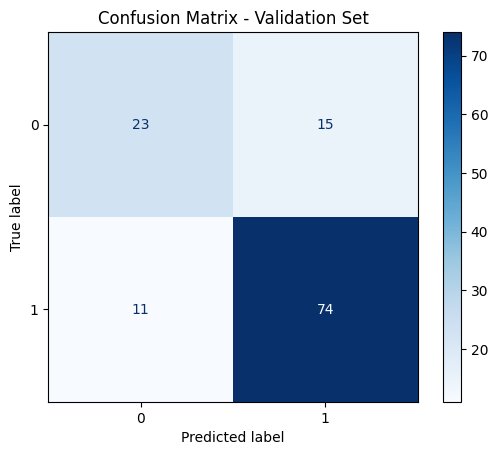

In [ ]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [ ]:
# Predict on training data
y_train_pred = model.predict(X_train)  # or X_train_smote if training on SMOTE data
train_acc = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_acc)

Training Accuracy: 0.9857433808553971


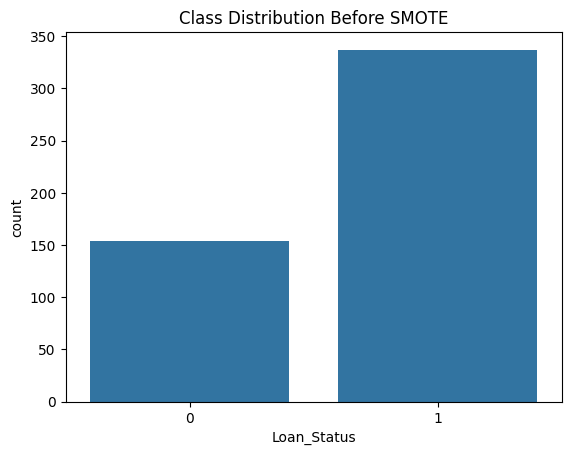

In [ ]:
sns.countplot(x=y_train)
plt.title('Class Distribution Before SMOTE')
plt.show()

HANDLING CLASS IMBALANCE USING SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [ ]:
model.fit(X_train_sm, y_train_sm)

y_pred_sm = model.predict(X_val)
print("Validation Accuracy after SMOTE:", accuracy_score(y_val, y_pred_sm))
print(classification_report(y_val, y_pred_sm))

Validation Accuracy after SMOTE: 0.7479674796747967
              precision    recall  f1-score   support

           0       0.58      0.68      0.63        38
           1       0.85      0.78      0.81        85

    accuracy                           0.75       123
   macro avg       0.71      0.73      0.72       123
weighted avg       0.76      0.75      0.75       123



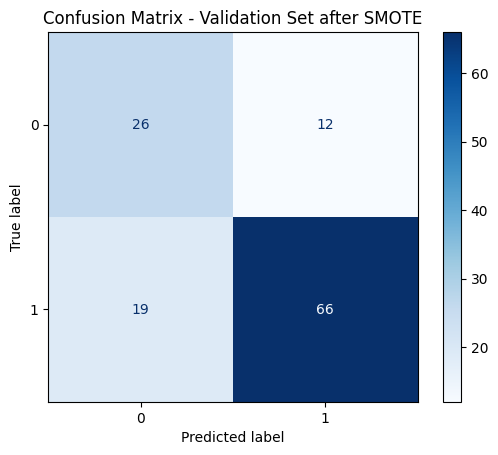

In [ ]:
cm = confusion_matrix(y_val, y_pred_sm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set after SMOTE")
plt.show()

In [ ]:
y_train_pred_sm = model.predict(X_train_sm)
train_acc_sm = accuracy_score(y_train_sm, y_train_pred_sm)
print("Training Accuracy on SMOTE data:", train_acc_sm)

Training Accuracy on SMOTE data: 0.9940652818991098


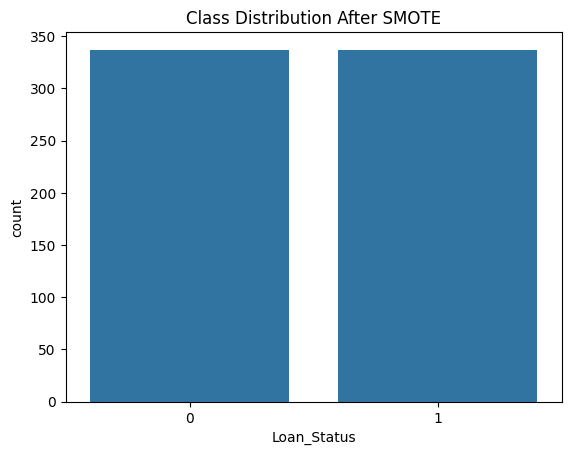

In [ ]:
sns.countplot(x=y_train_sm)
plt.title('Class Distribution After SMOTE')
plt.show()

SHAP EXPLANATIONS

Number of samples in validation set: 123


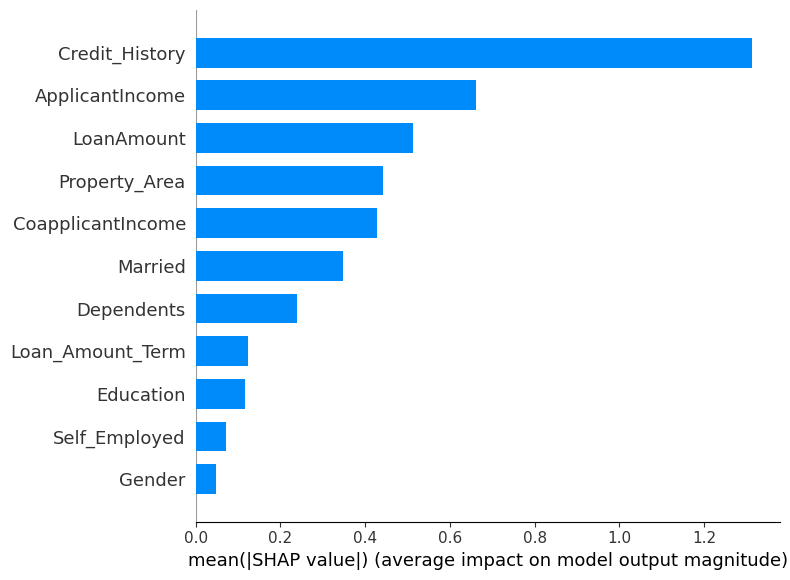

In [ ]:
# Assuming your model is trained: model
# X_val is your validation features (scaled, encoded, etc.)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

# Example: summary plot of feature importance for all validation samples
num_samples = X_val.shape[0]
print(f"Number of samples in validation set: {num_samples}")

shap.summary_plot(shap_values, X_val, plot_type="bar")

# WHICH FEATURE MOST INFLUENCE A REJECTION - GIVES SHAP VALUE PER FEATURE PER SAMPLE

In [ ]:
def shap_explanation_for_sample(shap_values, X_val, sample_index):
    # Get feature names and shap values for this sample
    feature_names = X_val.columns
    sample_shap_values = shap_values[sample_index]
    sample_features = X_val.iloc[sample_index]

    # Create a DataFrame of features with their SHAP impact values
    shap_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP Value': sample_shap_values,
        'Feature Value': sample_features
    }).sort_values(by='SHAP Value', key=abs, ascending=False)

    return shap_df
# We want to zoom in on one specific loan applicant and find out:
# What influenced the model to approve or reject their loan?
# Which features had the biggest effect?
# In what direction (positive or negative)?

In [ ]:
feature_explanations = {
    'Credit_History': "Your credit history is a major factor. A poor or missing credit history negatively affects approval.",
    'LoanAmount': "The loan amount you requested might be too high relative to your income.",
    'ApplicantIncome': "Your income level affects your ability to repay the loan.",
    'CoapplicantIncome': "If you have a co-applicant with sufficient income, it helps your application.",
    'Loan_Amount_Term': "The loan repayment term impacts your monthly payments and approval chances.",
    'Property_Area': "The location of the property can influence loan decisions.",
    'Dependents': "Number of dependents affects your financial obligations.",
    'Education': "Your education level may influence lender confidence.",
    'Self_Employed': "Being self-employed can affect your income stability assessment.",
    'Gender': "Gender may have indirect influences in credit decisions.",
    'Married': "Marital status might be considered for loan approval.",
    # Add more if needed
}

def generate_layman_text(shap_df):
    top_features = shap_df.head(3)
    messages = []
    for _, row in top_features.iterrows():
        feat = row['Feature']
        val = row['Feature Value']
        impact = row['SHAP Value']

        # Custom explanations depending on feature and value
        if feat == 'Credit_History':
            if val == 0:
                explanation = "Your credit history is missing or poor, which strongly decreases your chance."
            else:
                explanation = "You have a good credit history, positively influencing your application."
        elif feat == 'LoanAmount':
            if val > 0.5:  # since scaled, check threshold accordingly
                explanation = "The loan amount you requested is quite high compared to typical amounts, which may reduce approval chances."
            else:
                explanation = "Your requested loan amount is reasonable."
        elif feat == 'ApplicantIncome':
            if val < 0:
                explanation = "Your income is lower than average, which might limit repayment ability."
            else:
                explanation = "Your income is healthy, helping your loan approval."
        else:
            # Fallback generic explanation
            explanation = feature_explanations.get(feat, f"{feat} affects your loan decision.")

        direction = "negatively" if impact < 0 else "positively"
        messages.append(f"{explanation} This feature influenced your loan application {direction} with a value of {val:.2f}.")

    return "\n".join(messages)

def generate_advice(shap_df):
    # Focus on features negatively impacting loan approval
    negative_feats = shap_df[shap_df['SHAP Value'] < 0]
    advices = []
    for _, row in negative_feats.iterrows():
        feat = row['Feature']
        if feat == 'Credit_History':
            advices.append("Try to improve your credit score or provide proof of past good credit.")
        elif feat == 'LoanAmount':
            advices.append("Consider requesting a smaller loan amount to increase chances of approval.")
        elif feat == 'ApplicantIncome':
            advices.append("Increasing your income or showing additional sources of income can help.")
        elif feat == 'CoapplicantIncome':
            advices.append("Adding a co-applicant with a stable income may improve your chances.")
        elif feat == 'Loan_Amount_Term':
            advices.append("Consider selecting a longer repayment term to reduce EMI burden.")
        elif feat == 'Self_Employed':
            advices.append("Provide financial records to show income stability if self-employed.")
        elif feat == 'Dependents':
            advices.append("If possible, reduce financial obligations or highlight other support sources.")
        elif feat == 'Education':
            advices.append("Showcase additional qualifications or financial literacy if applicable.")
        elif feat == 'Property_Area':
            advices.append("Highlight value or resale potential of the property to strengthen your case.")
        elif feat == 'Gender':
            advices.append("Ensure all other factors are strong to mitigate bias, if any.")
        elif feat == 'Married':
            advices.append("Provide documentation about dual income if applicable.")
        else:
            advices.append(f"Consider improving or clarifying your {feat.lower().replace('_', ' ')}.")

    if not advices:
        advices.append("You're doing great! Try contacting the lender to clarify any specific concerns.")

    return "\n".join(advices)


# USES DICTIONARY TO MAP TECHNICAL TERMS WITH VERBAL TERMS - CREDIT = 0.0 - YOUR CREDIT HSTORY IS MISSING

In [ ]:
def plot_shap_pie_chart(shap_df):
    # Use absolute SHAP values for proportions
    labels = shap_df['Feature'][:5]  # Top 5 features
    sizes = shap_df['SHAP Value'][:5].abs()
    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Feature Contribution to Loan Decision')
    plt.show()

# GRAPHICAL REPRESENTATION OF TOP 5 FEATURES THAT INFLUENCED IN DECISION AND IMPACT SHARE

📢 Loan Status: ❌ Rejected

📝 Explanation:
You have a good credit history, positively influencing your application. This feature influenced your loan application negatively with a value of -2.43.
Number of dependents affects your financial obligations. This feature influenced your loan application positively with a value of 3.00.
Your requested loan amount is reasonable. This feature influenced your loan application positively with a value of 0.15.

💡 Suggestions:
Try to improve your credit score or provide proof of past good credit.
Provide financial records to show income stability if self-employed.
Ensure all other factors are strong to mitigate bias, if any.



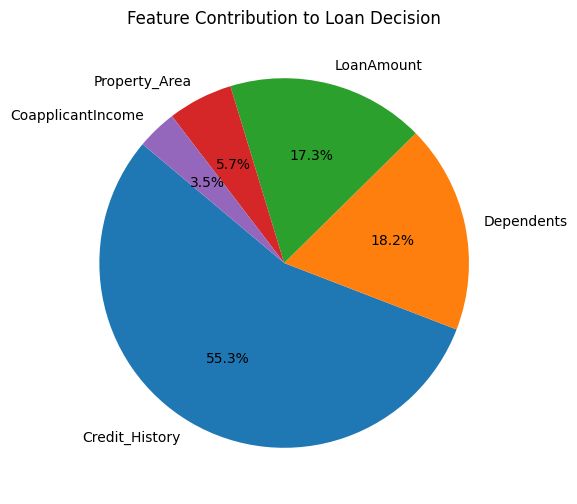

In [ ]:
def generate_final_loan_report(approved: bool, layman_text: str, advice_text: str) -> str:
    status_icon = "✅ Approved" if approved else "❌ Rejected"
    header = f"📢 Loan Status: {status_icon}\n\n"
    explanation_section = f"📝 Explanation:\n{layman_text.strip()}\n\n"
    suggestions_section = f"💡 Suggestions:\n{advice_text.strip()}\n"
    return header + explanation_section + suggestions_section

def view_loan_report_for_sample(index):
    explanation_df = shap_explanation_for_sample(shap_values, X_val, index)
    layman_text = generate_layman_text(explanation_df)
    advice_text = generate_advice(explanation_df)
    approved = y_val.iloc[index] == 1
    final_report = generate_final_loan_report(approved, layman_text, advice_text)
    print(final_report)
    plot_shap_pie_chart(explanation_df)


# Try a different sample
view_loan_report_for_sample(120)


SAVING THE MODEL

In [ ]:
# Ensure directory exists
os.makedirs('model', exist_ok=True)

# Save label encoders
if label_encoders:
    for col, le in label_encoders.items():
        path = f'models/{col}_label_encoder.pkl'
        joblib.dump(le, path)
        print(f"✅ Saved encoder: {path}")
else:
    print("❌ label_encoders dictionary is empty. Cannot save encoders.")

# Save scaler
if 'scaler' in globals() and scaler is not None:
    joblib.dump(scaler, 'models/scaler.pkl')
    print("✅ Saved scaler successfully.")
else:
    print("❌ Scaler not found or None.")

# Save model
if 'model' in globals() and model is not None:
    joblib.dump(model, 'models/loan_model.pkl')
    print("✅ Saved model successfully.")
else:
    print("❌ Model variable not found or is None.")

# Save SHAP explainer
if 'explainer' in globals() and explainer is not None:
    joblib.dump(explainer, 'models/shap_explainer.pkl')
    print("✅ Saved SHAP explainer successfully.")
else:
    print("❌ Explainer not found or is None.")

# Save feature names
if 'feature_names' in globals() and feature_names is not None:
    with open('models/feature_names.pkl', 'wb') as f:
        pickle.dump(feature_names, f)
    print("✅ Saved feature names successfully.")
elif 'X_val' in globals() and X_val is not None and hasattr(X_val, 'columns'):
    feature_names_derived = X_val.columns.tolist()
    with open('models/feature_names.pkl', 'wb') as f:
        pickle.dump(feature_names_derived, f)
    print("✅ Derived and saved feature names from X_val.")
else:
    print("❌ Feature names variable not found and could not derive from X_val.")


✅ Saved encoder: models/gender_label_encoder.pkl
✅ Saved encoder: models/education_label_encoder.pkl
✅ Saved scaler successfully.
✅ Saved model successfully.
❌ Explainer not found or is None.
✅ Saved feature names successfully.


TESTING THE MODEL

In [ ]:
# Upload test file
uploaded = files.upload()

# Load test data
# Corrected filename to match the uploaded file name 'test_lAU.csv'
test_df = pd.read_csv("test_lAU.csv")

print("Test dataset loaded successfully!")
print(test_df.head())

Saving test_lAU.csv to test_lAU.csv
Test dataset loaded successfully!
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001015   Male     Yes          0      Graduate            No   
1  LP001022   Male     Yes          1      Graduate            No   
2  LP001031   Male     Yes          2      Graduate            No   
3  LP001035   Male     Yes          2      Graduate            No   
4  LP001051   Male      No          0  Not Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5720                  0       110.0             360.0   
1             3076               1500       126.0             360.0   
2             5000               1800       208.0             360.0   
3             2340               2546       100.0             360.0   
4             3276                  0        78.0             360.0   

   Credit_History Property_Area  
0             1.0         Urban  
1             1.0   

In [ ]:
print(scaler.feature_names_in_)

['ApplicantIncome' 'CoapplicantIncome' 'LoanAmount' 'Credit_History']


In [ ]:
# Load saved preprocessing and model components
# Ensure these files were saved in previous steps
try:
    scaler = joblib.load('models/scaler.pkl')
    model = joblib.load('models/loan_model.pkl')
    explainer = joblib.load('models/shap_explainer.pkl')
    feature_names = joblib.load('models/feature_names.pkl')

    categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Amount_Term']

    label_encoders = {}
    for col in categorical_columns:
        # This is the line that failed
        label_encoders[col] = joblib.load(f'models/{col}_label_encoder.pkl')
        print(f"✅ Loaded encoder for: {col}") # Optional: Add print statements
except FileNotFoundError as e:
    print(f"❌ Error loading file: {e}")
    print("Please ensure all necessary model and preprocessing files are saved in the 'models/' directory.")
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")

✅ Loaded encoder for: Gender
✅ Loaded encoder for: Married
✅ Loaded encoder for: Dependents
✅ Loaded encoder for: Education
✅ Loaded encoder for: Self_Employed
✅ Loaded encoder for: Property_Area
✅ Loaded encoder for: Loan_Amount_Term


In [ ]:
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Amount_Term']
print("Missing columns:", [col for col in categorical_columns if col not in df.columns])


Missing columns: []


In [ ]:
!ls models

Dependents_label_encoder.pkl	    Married_label_encoder.pkl
Education_label_encoder.pkl	    Property_Area_label_encoder.pkl
feature_names.pkl		    scaler.pkl
Gender_label_encoder.pkl	    Self_Employed_label_encoder.pkl
Loan_Amount_Term_label_encoder.pkl  shap_explainer.pkl
loan_model.pkl


PREPROCESS TEST DATA

In [ ]:
print("Missing values in test data:")
print(test_df.isnull().sum())

Missing values in test data:
Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


In [ ]:
# Assuming df is your training DataFrame
default_fill_values = {
    col: df[col].mode()[0] for col in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
}
default_fill_values['Loan_Amount_Term'] = df['Loan_Amount_Term'].mode()[0]
default_fill_values['Credit_History'] = df['Credit_History'].mode()[0]
default_fill_values['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())


# Fill test_df only where necessary
test_df.fillna(default_fill_values, inplace=True)

In [ ]:
print("Missing values in test data:")
print(test_df.isnull().sum())

Missing values in test data:
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64


ENCODE AND SCALE TEST DATA

In [ ]:
# Encode categorical columns using saved label encoders
for col in categorical_columns:
    le = label_encoders[col]
    test_df[col] = test_df[col].apply(lambda x: x if x in le.classes_ else le.classes_[0])
    test_df[col] = le.transform(test_df[col])

# Scale numerical columns
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History']
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

# Prepare feature matrix
X_test = test_df.drop(columns=['Loan_ID'], errors='ignore')

In [ ]:
# Make predictions
y_test_pred = model.predict(X_test)

In [ ]:
shap_values_test = explainer.shap_values(X_test)
print("Number of test samples:", test_df.shape[0])

Number of test samples: 367


MAKE PREDICTIONS

📢 Loan Status: ❌ Rejected

📝 Explanation:
Your income is lower than average, which might limit repayment ability. This feature influenced your loan application negatively with a value of -0.25.
Your requested loan amount is reasonable. This feature influenced your loan application negatively with a value of 0.01.
You have a good credit history, positively influencing your application. This feature influenced your loan application positively with a value of -2.43.

💡 Suggestions:
Increasing your income or showing additional sources of income can help.
Consider requesting a smaller loan amount to increase chances of approval.
If possible, reduce financial obligations or highlight other support sources.
Ensure all other factors are strong to mitigate bias, if any.



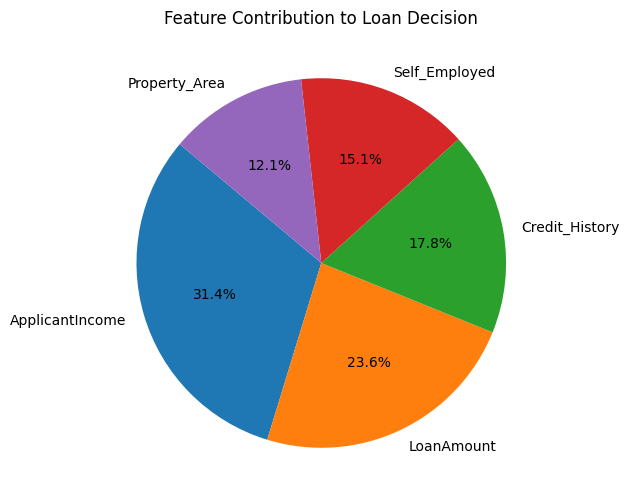

In [ ]:
def view_loan_report_for_sample(index):
    explanation_df = shap_explanation_for_sample(shap_values, X_test, index)
    layman_text = generate_layman_text(explanation_df)
    advice_text = generate_advice(explanation_df)
    approved = y_test_pred[index] == 1
    final_report = generate_final_loan_report(approved, layman_text, advice_text)
    print(final_report)
    plot_shap_pie_chart(explanation_df)
view_loan_report_for_sample(7)

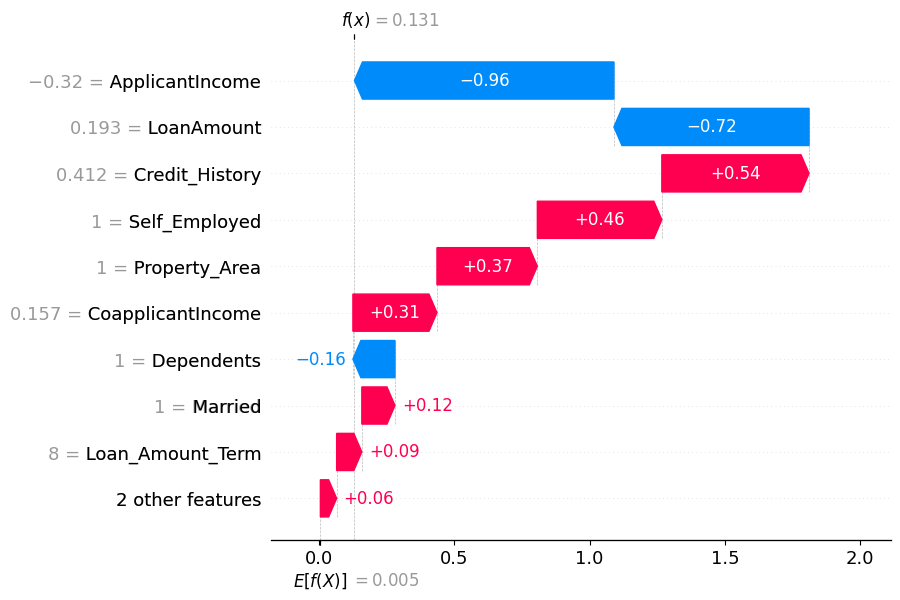

In [ ]:
shap.plots.waterfall(shap.Explanation(values=shap_values[7],
                                      base_values=explainer.expected_value,
                                      data=X_val.iloc[7],
                                      feature_names=X_val.columns.tolist()))
#Change the SHAP index value(x) - shap_values[x]

✅ Approved Loans: 222
❌ Rejected Loans: 145


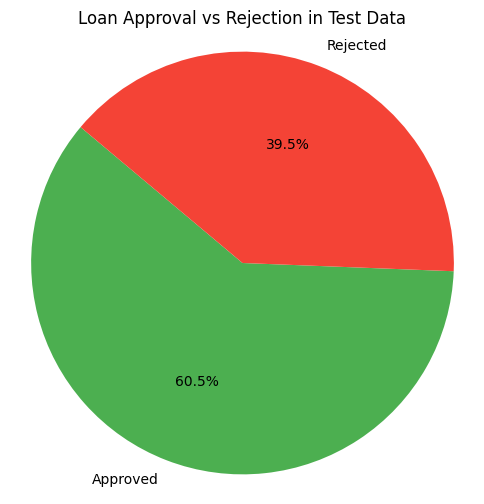

In [ ]:
y_test_pred = model.predict(X_test)  # 1 = Approved, 0 = Rejected
approved_count = np.sum(y_test_pred == 1)
rejected_count = np.sum(y_test_pred == 0)

print(f"✅ Approved Loans: {approved_count}")
print(f"❌ Rejected Loans: {rejected_count}")

labels = ['Approved', 'Rejected']
sizes = [approved_count, rejected_count]
colors = ['#4CAF50', '#F44336']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Loan Approval vs Rejection in Test Data')
plt.axis('equal')
plt.show()

In [ ]:
reports = []

for idx in range(X_test.shape[0]):
    explanation_df = shap_explanation_for_sample(shap_values_test, X_test, idx)
    layman_text = generate_layman_text(explanation_df)
    advice_text = generate_advice(explanation_df)
    approved = y_test_pred[idx] == 1
    report_text = generate_final_loan_report(approved, layman_text, advice_text)

    reports.append({
        'Loan_ID': test_df.iloc[idx]['Loan_ID'] if 'Loan_ID' in test_df.columns else f"Sample_{idx}",
        'Loan_Status': 'Approved' if approved else 'Rejected',
        'Report': report_text
    })

# Save as CSV
report_df = pd.DataFrame(reports)
report_df.to_csv('loan_decision_reports.csv', index=False)
print("✅ Reports saved to 'loan_decision_reports.csv'")


✅ Reports saved to 'loan_decision_reports.csv'


In [ ]:
# Get predicted probabilities for class 1 (Approved)
y_test_proba = model.predict_proba(X_test)[:, 1]

# Show top 5 probabilities
import pandas as pd
proba_df = pd.DataFrame({
    'Loan_ID': test_df['Loan_ID'],
    'Prediction': y_test_pred,
    'Approval_Probability': y_test_proba
})

print(proba_df.head())


    Loan_ID  Prediction  Approval_Probability
0  LP001015           1              0.599438
1  LP001022           1              0.972474
2  LP001031           1              0.879301
3  LP001035           0              0.068056
4  LP001051           0              0.424861
